#  Brain-body-behavior descriptors ME

## Descriptors recap
- Brain: (1) one arity functions / n nodes, (2) two arity functions / n nodes
- Body: (1) elongation, (2) n voxels / n max voxels
- Behavior: (1) y-velocity, (2) average voxel angle (values over simulation -> fft -> median of energy -> normalized in [0,1])  

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from qdax.utils.plotting import plot_2d_map_elites_repertoire
from scipy.stats import ranksums
%matplotlib inline

In [44]:
dfs = []
for sampler in ["all", "s1", "s2", "s3", "me"]:
    for seed in range(10):
        try:
            tmp_df = pd.read_csv(f"../results/evo-body-5x5-me-{sampler}_{seed}.csv")
            tmp_df["sampler"] = sampler
            tmp_df["seed"] = seed
            dfs.append(tmp_df)
        except FileNotFoundError:
            print(sampler, seed)
df = pd.concat(dfs)
df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,sampler,seed
0,1,0.498079,-4.571014,-3.111709,-0.778685,6.054688,3.515625,4.199219,10.259820,2024-04-04 13:17:12.380361,all,0
1,2,0.498079,-3.563980,-0.986565,2.178715,8.300781,3.613281,5.273438,6.047399,2024-04-04 13:17:18.428084,all,0
2,3,0.567185,-0.024876,2.097297,4.358453,9.667969,4.003906,6.835938,5.925249,2024-04-04 13:17:24.353723,all,0
3,4,0.567185,5.165858,2.803247,6.230591,10.839844,4.199219,8.398438,6.185898,2024-04-04 13:17:30.540099,all,0
4,5,0.567185,8.109872,3.158883,6.720121,12.011719,4.589844,9.960938,6.159141,2024-04-04 13:17:36.699699,all,0


In [45]:
final_df = df[df["iteration"] == max(df["iteration"])]
final_df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,sampler,seed
3999,4000,8.421682,1392.3450,920.99460,1853.0740,41.699220,29.199219,58.789062,6.067569,2024-04-04 19:57:47.175975,all,0
3999,4000,8.692507,1463.6128,875.13336,2568.0737,41.113280,29.003906,55.957030,7.977662,2024-03-26 10:44:00.199355,all,1
3999,4000,6.322092,1256.0234,876.77480,2149.9863,40.917970,29.199219,64.160160,8.046634,2024-03-26 19:47:52.522101,all,2
3999,4000,8.981209,1447.1480,1033.71200,2505.6420,39.453125,29.980469,58.007812,7.854472,2024-03-29 03:00:36.046996,all,3
3999,4000,5.825763,1126.3091,819.85986,1980.7699,39.550780,29.101562,59.375000,7.865317,2024-03-29 11:56:57.485572,all,4


## Fitness results
- no convergence yet, how many more iterations would it require?
- sampling from all repertoires is better in median, but not statistically significant; joint ME follows immediately
- body diversity seems the least important for performance, does it depend on coverage/descriptors?

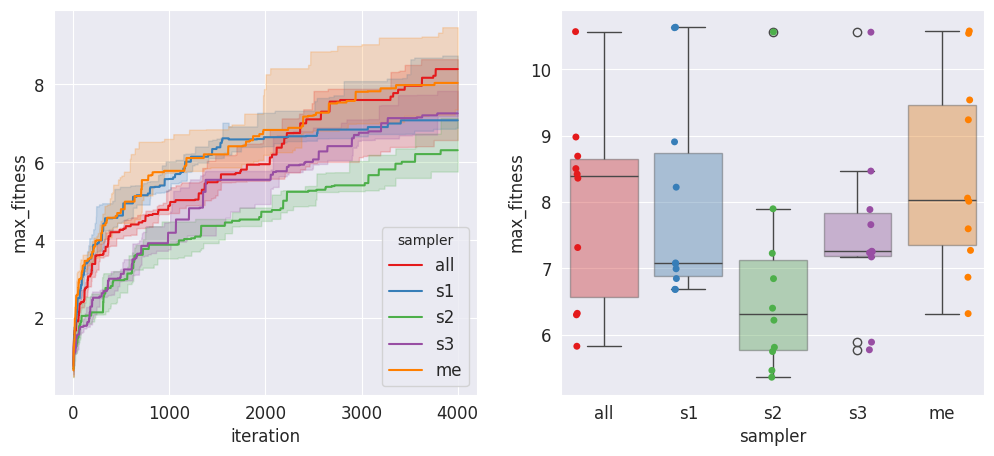

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(df,
             x="iteration",
             y="max_fitness",
             estimator="median",
             errorbar=("pi", 50),
             hue="sampler",
             palette="Set1",
             ax=axs[0]
             )
sns.boxplot(
    final_df,
    x="sampler",
    y="max_fitness",
    hue="sampler",
    palette="Set1",
    boxprops={'alpha': 0.4},
    ax=axs[1]
)
sns.stripplot(final_df,
              x="sampler",
              y="max_fitness",
              hue="sampler",
              palette="Set1",
              dodge=True,
              ax=axs[1])
plt.show()

In [47]:
pairs = []
for s1 in final_df.sampler.unique():
    for s2 in final_df.sampler.unique():
        if s1 != s2 and (s2, s1) not in pairs:
            pairs.append((s1, s2))
            fits1 = final_df[final_df["sampler"] == s1]["max_fitness"].to_list()
            fits2 = final_df[final_df["sampler"] == s2]["max_fitness"].to_list()
            _, p_value = ranksums(fits1, fits2)
            print(f"{s1} vs {s2} -> {p_value}")

all vs s1 -> 1.0
all vs s2 -> 0.04125001659393949
all vs s3 -> 0.28991845394256976
all vs me -> 0.5967012167293563
s1 vs s2 -> 0.034293721036492766
s1 vs s3 -> 0.9397429895770734
s1 vs me -> 0.49629170223109287
s2 vs s3 -> 0.09630369202868826
s2 vs me -> 0.012611144099313947
s3 vs me -> 0.15092695006671628


## Coverage results
- sampling from repertoire x fosters diversity/coverage in x
- sampling from all repertoires is the second-best option for each, i.e., the best trade-off
- as before, ME has the worst coverage 

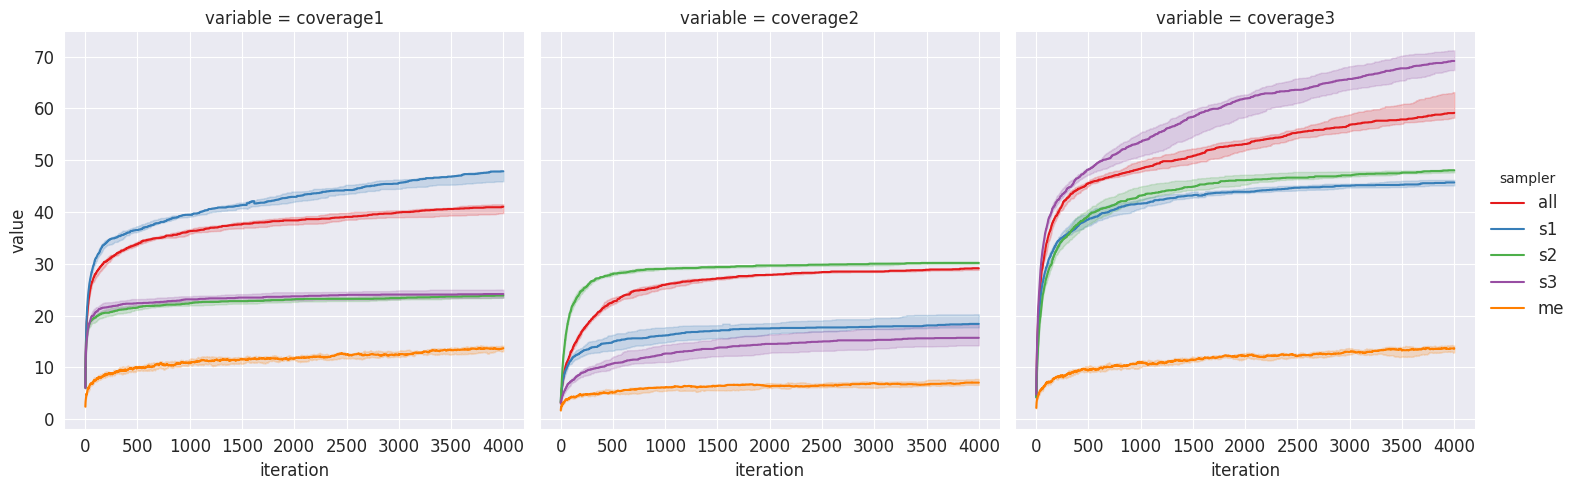

In [48]:
df_wide = pd.melt(df, id_vars=["iteration", "max_fitness", "time", "current_time", "sampler", "seed"],
                  value_vars=["coverage1", "coverage2", "coverage3"])
sns.relplot(df_wide,
            x="iteration",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="line",
            estimator="median",
            errorbar=("pi", 50),
            )
plt.show()

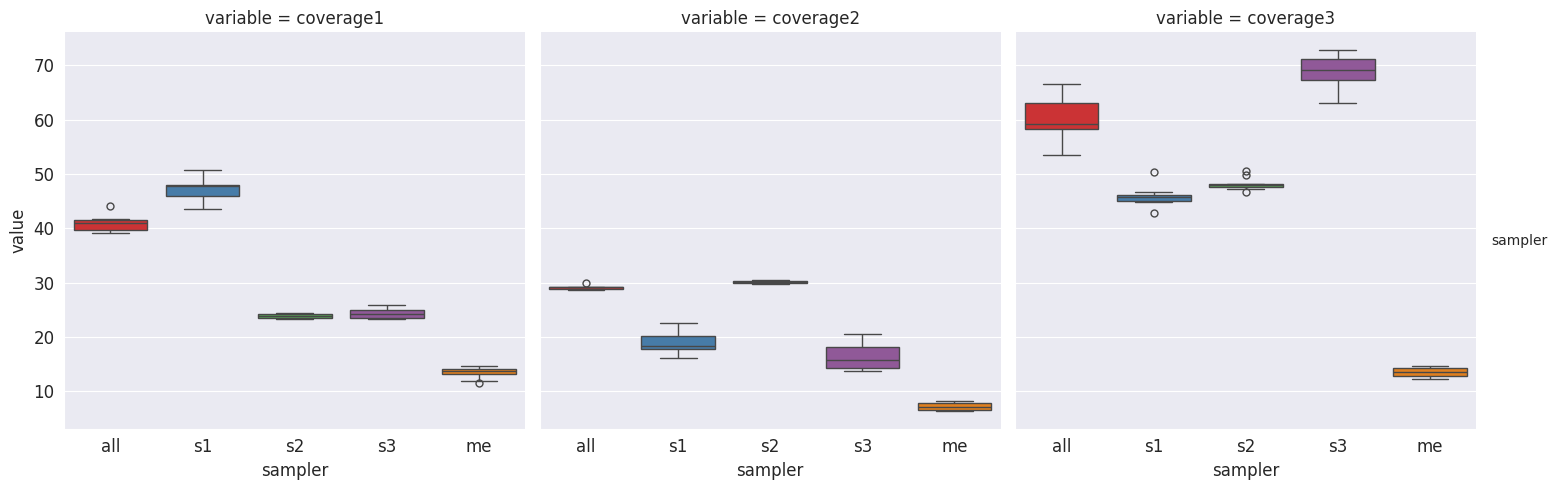

In [49]:
final_df_wide = df_wide[df_wide["iteration"] == max(df_wide["iteration"])]
sns.catplot(final_df_wide,
            x="sampler",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="box",
            )
plt.show()

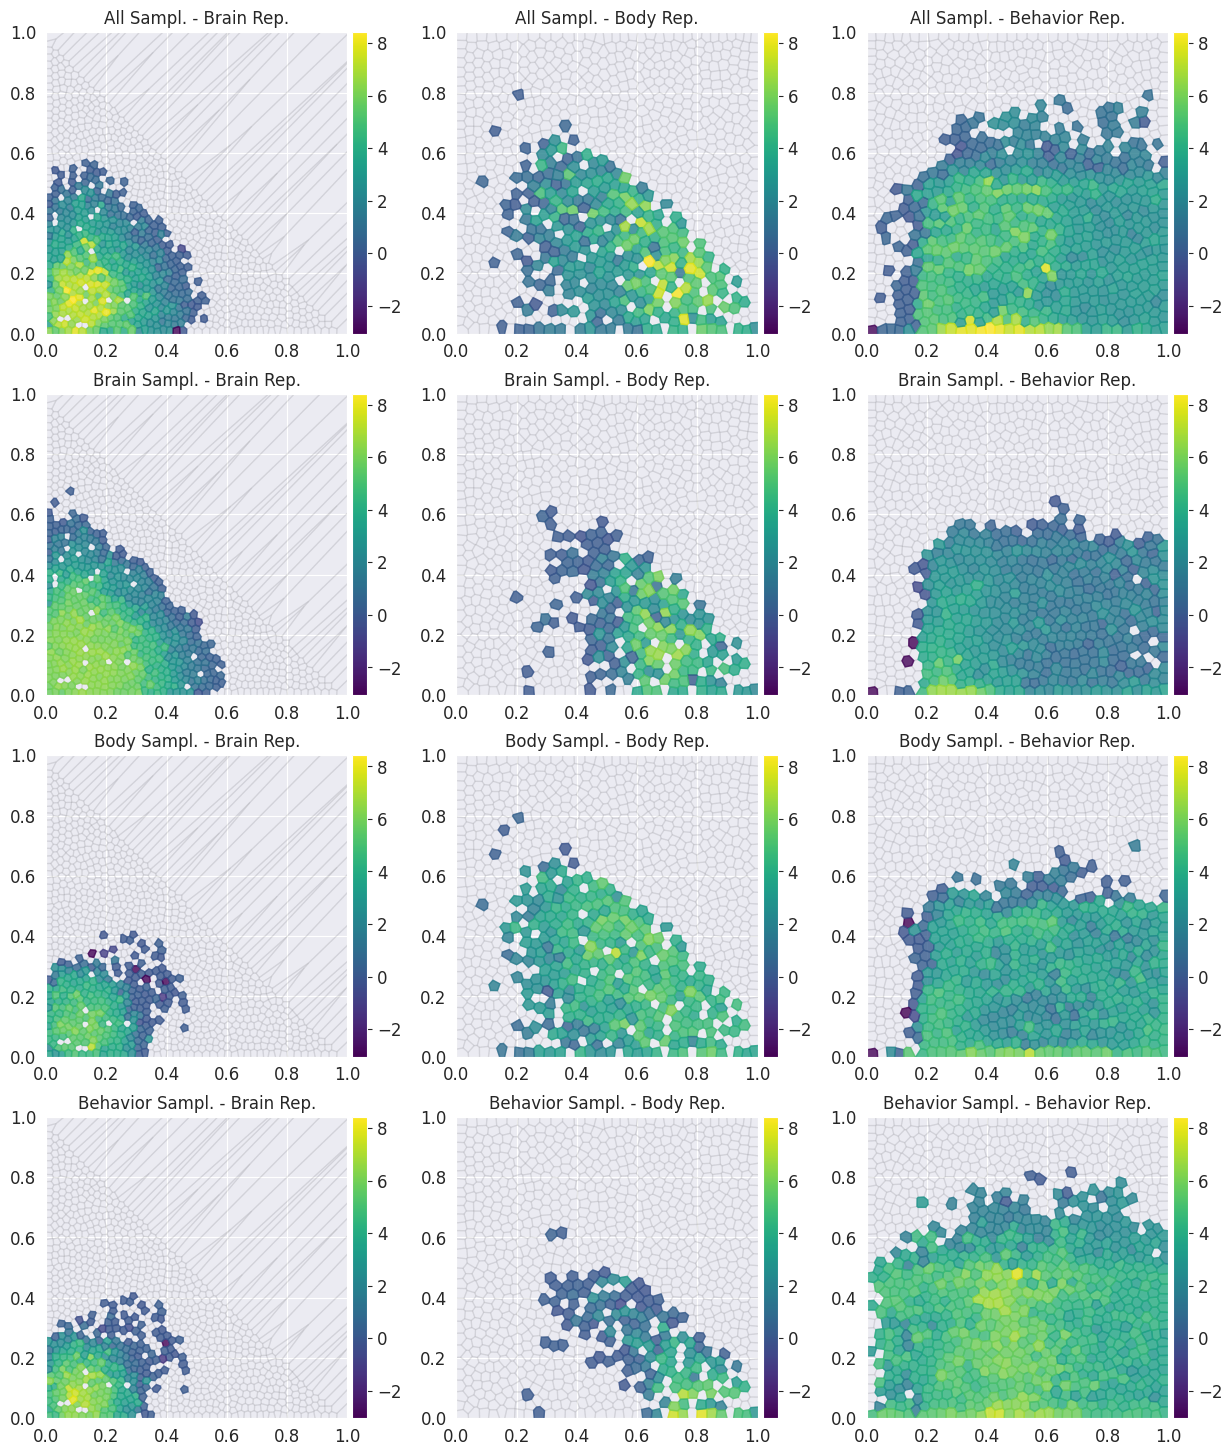

In [50]:
samplers = ["all", "s1", "s2", "s3"]
fig, axs = plt.subplots(4, 3, figsize=(15, 18))
reps = {
    0: "Brain",
    1: "Body",
    2: "Behavior"
}
sams = {
    "all": "All",
    "s1": "Brain",
    "s2": "Body",
    "s3": "Behavior"
}
min_fit, max_fit = jnp.inf, -jnp.inf
for i, sampler in enumerate(samplers):
    base_path = f"../results/evo-body-5x5-me-{sampler}_0"
    for r, ax in enumerate(axs[i]):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        curr_min_fit, curr_max_fit = min(fitnesses[fitnesses > -jnp.inf]), max(fitnesses)
        if curr_min_fit < min_fit: min_fit = curr_min_fit
        if curr_max_fit > max_fit: max_fit = curr_max_fit

for i, sampler in enumerate(samplers):
    base_path = f"../results/evo-body-5x5-me-{sampler}_0"
    for r, ax in enumerate(axs[i]):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        plot_2d_map_elites_repertoire(centroids, fitnesses, 0, 1, ax=ax, vmin=min_fit, vmax=max_fit)
        ax.set_title(f"{sams[sampler]} Sampl. - {reps[r]} Rep.")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.show()